In [1]:
import subprocess
import time
import os 
import sys 
import io
import functions
import importlib
import inspect

import warnings 
warnings.filterwarnings('ignore')



In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
importlib.reload(functions)
from functions import *

pd.set_option('display.max_columns', 100)

# Get all functions in the module
functions_list = [f[0] for f in inspect.getmembers(functions, inspect.isfunction)]
print(functions_list)

['convert_age', 'drop_dups', 'get_BES_data', 'get_data', 'merge_results', 'yougov_polls']


## Note:

You will need to download the BES data from the BES website. All other data are included in the repo 

In [4]:
## Read in the dataset as a stata file and then save it as a pickle file, restart the kernel and then read in the pickle file to save on memory (the pickle file is much smaller and faster to read in than the stata file)


 


bes_data_path = '/home/zach/Dept of Methodology Dropbox/Zachary Dickson/main/Joint_projects_zach_sara/NHS_wait_times/analysis/data/BES2019_W25String/bes_panel_ukds_w1w25_v1.dta'

#df = pd.read_stata(bes_data_path)


#ndf = get_BES_data(df, min_vars=15, max_vars=25)



In [5]:
####### I saved the final long version as a pickle file so I can just read that in and not have to run the above code again
#df.to_pickle('data/bes_data_long.pkl')
df = pd.read_pickle('data/bes_data_long.pkl')

In [7]:
df.starttime = pd.to_datetime(df.starttime)
df.endtime = pd.to_datetime(df.endtime)

In [8]:
## impute missing location codes for individuals who provided a code at some point in the survey but did not provide the code for the other waves. The assumes that the location code is the same for all waves for a given individual

df = impute_loc_codes(df)

In [11]:
## create dummies for all categorical variables and string variables. This is necessary for the machine learning models

df = create_dummies(df)

100%|██████████| 88/88 [03:40<00:00,  2.50s/it]


In [158]:
## assign a variable that indicates that the survey was taken 3-4 waves BEFORE the election. YOu can change the number of waves before the election by changing the fucntion 
df = assign_elections(df)

- 2015 UK general election: 2015-05-07
- 2017 UK general election: 2017-06-08
- 2019 UK general election: 2019-12-12




In [13]:
## read in past election results - from Ben Ansell's GitHub page

results = pd.read_csv('data/ge_19_hp_all.csv')
results

,ons_const_id,constituency_name,country,region,constituency_type,winner_17,con_17,lab_17,ld_17,snp_17,pc_17,ukip_17,green_17,other_17,majority_17,turnout_17,electorate_17,winner_15,con_15,lab_15,ld_15,snp_15,pc_15,ukip_15,green_15,other_15,majority_15,turnout_15,winner_10,con_10,lab_10,ld_10,snp_10,pc_10,ukip_10,green_10,bnp_10,majority_10,turn_10,leave_hanretty,remain_hanretty,party_id,party_colour,Constituency,reg_voters_19,turnout_19,electorate_19,con_19,lab_19,lib_19,green_19,snp_19,pc_19,bxp_19,ukip_19,other_19,winner_19,display_as,gender.x,member_from,party_text,party_winner,age,display_as_19,gender.y,member_from_19,party_winner_19,age_19
0,W07000049,Aberavon,Wales,Wales,County,Labour,17.737766,68.119514,1.800529,0.000000,8.299267,4.042924,0.0,0.000000,50.381748,66.680029,49892,Labour,11.870698,48.903975,4.431685,0.000000,11.620087,15.769438,2.255496,5.148622,33.134537,63.272516,Labour,14.25,51.92,16.26,0.00,7.10,1.58,0.00,4.12,35.7,61.0,60.124484,39.875516,15,#DC241F,Aberavon,50747,0.622657,31598,20.627888,53.826192,3.392620,1.424141,0.000000,8.579657,9.836066,0.000000,2.313438,LAB,Stephen Kinnock,M,Aberavon,Labour,Lab,49.989155,Stephen Kinnock,M,Aberavon,Labour,49.989041
1,W07000058,Aberconwy,Wales,Wales,County,Conservative,44.594090,42.618974,2.926905,0.000000,9.860031,0.000000,0.0,0.000000,1.975117,71.048154,45251,Conservative,41.505241,28.240679,4.613905,0.000000,11.728805,11.499934,2.411437,0.000000,13.264561,66.222954,Conservative,35.82,24.48,19.31,0.00,17.82,2.11,0.00,NaN,11.3,67.2,52.197117,47.802883,4,#0087DC,Aberconwy,44699,0.712879,31865,46.091323,39.708144,5.714734,0.000000,0.000000,8.485799,0.000000,0.000000,0.000000,CON,Guto Bebb,M,Aberconwy,Independent,Con,51.219292,Robin Millar,M,Aberconwy,Conservative,NaN
2,S14000001,Aberdeen North,Scotland,Scotland,Borough,Scottish National Party,22.692276,30.010610,4.605925,41.271050,0.000000,0.000000,0.0,1.420138,11.260440,59.161436,62130,Scottish National Party,12.072105,25.940004,4.665878,56.429807,0.000000,0.000000,0.000000,0.892207,30.489803,64.854971,Labour,12.38,44.42,18.57,22.24,0.00,0.00,0.00,1.68,22.2,58.2,43.092209,56.907791,29,#FFFF00,Aberdeen North,62489,0.598713,37413,20.140058,13.201294,7.606982,2.352124,54.005292,0.000000,2.694251,0.000000,0.000000,SNP,Kirsty Blackman,F,Aberdeen North,Scottish National Party,SNP,33.764384,Kirsty Blackman,F,Aberdeen North,Scottish National Party,33.764384
3,S14000002,Aberdeen South,Scotland,Scotland,Borough,Conservative,42.132470,20.549300,5.866091,31.452139,0.000000,0.000000,0.0,0.000000,10.680332,68.488701,64964,Scottish National Party,22.835781,26.757430,4.638421,41.648988,0.000000,1.847542,1.985541,0.286297,14.891557,71.339779,Labour,20.71,36.53,28.39,11.86,0.00,0.00,0.96,1.23,8.2,67.2,32.143105,67.856895,4,#0087DC,Aberdeen South,65719,0.694441,45638,35.930584,8.400894,10.995223,0.000000,44.673299,0.000000,0.000000,0.000000,0.000000,SNP,Ross Thomson,M,Aberdeen South,Conservative,Con,32.257648,Stephen Flynn,M,Aberdeen South,Scottish National Party,NaN
4,S14000058,West Aberdeenshire and Kincardine,Scotland,Scotland,County,Conservative,47.852785,11.052785,8.641162,32.453269,0.000000,0.000000,0.0,0.000000,15.399516,71.229493,72477,Scottish National Party,28.835423,4.505761,21.400101,41.577288,0.000000,1.822596,1.603377,0.255453,12.741865,75.152835,Liberal Democrat,30.26,13.63,38.42,15.68,0.00,0.88,0.00,1.14,8.2,68.4,38.519483,61.480517,4,#0087DC,Aberdeenshire West & Kincardine,72640,0.734375,53345,42.650670,4.557128,11.721811,0.000000,41.070391,0.000000,0.000000,0.000000,0.000000,CON,Andrew Bowie,M,West Aberdeenshire and Kincardine,Conservative,Con,32.575457,Andrew Bowie,M,West Aberdeenshire and Kincardine,Conservative,32.575342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,N06000014,South 

In [159]:
# merge the election results with the BES data

df = merge_results(df, results, 2015)
df = merge_results(df, results, 2017)
df = merge_results(df, results, 2019)

In [160]:
# drop rows with no constituency data that are in the past election years 

remove = df.loc[(df.con_target.isna())&(df.election.isin([2015,2017,2019]))].index 

df = df.drop(remove)


In [161]:
# drop duplicate columns
df = df.loc[:,~df.columns.duplicated()]

In [162]:
df_agg = df.groupby(['pcon_code_imputed', 'election']).mean(numeric_only=True).reset_index()

In [ ]:
# add missing ONS variables to the dataset
df_agg = add_missing_ons_vars(df, df_agg)

# Get msoa 11 and msoa 21 codes for data 

In [163]:
# convert msoa11 to msoa21

msoa12 = pd.read_csv('data/MSOA_(2011)_to_MSOA_(2021).csv')

msoa12_dict = dict(zip(msoa12['MSOA11CD'], msoa12['MSOA21CD']))

df_agg['MSOA21CD_imputed'] = df_agg['msoa11_imputed'].map(msoa12_dict)

In [165]:
# convert the msoa21 to pcon25
msoa21_west = pd.read_csv('data/MSOA_(2021)_to_future_Parliamentary_Constituencies_Lookup_in_England_and_Wales.csv')

msoa21_west_dict = dict(zip(msoa21_west['MSOA21CD'], msoa21_west['PCON25CD']))

df_agg['PCON25CD_imputed'] = df_agg['MSOA21CD_imputed'].map(msoa21_west_dict)


# Add polling data for 2015, 2017, 2019 UK general elections

 [https://www.markpack.org.uk/files/2024/05/PollBase-Q1b-2024-general-election-version.xlsx](https://www.markpack.org.uk/files/2024/05/PollBase-Q1b-2024-general-election-version.xlsx)

 there is a better way to do this that'll be a project for another day 

In [33]:
def get_polls(election_term, year):
    x = pd.read_excel('https://www.markpack.org.uk/files/2024/05/PollBase-Q1b-2024-general-election-version.xlsx', sheet_name=election_term)
    x = x.loc[x['Year'] == year]
    #return x 
    if 'Ukip' in x.columns:
        x['UKIP'] = x['Ukip']
    x = x[['Con', 'Lab', 'LD', 'Green','UKIP', 'Con Best PM', 'Lab Best PM', 'LD Best PM']]
    x['election'] = year
    return x 

polls_2015 = get_polls('10-15', 2015)
polls_2017 = get_polls('15-17', 2017)
polls_2019 = get_polls('17-19', 2019)
polls_2024 = get_polls('19-', 2024)



In [166]:
polls = pd.concat([polls_2015, polls_2017, polls_2019, polls_2024])
polls

,Con,Lab,LD,Green,UKIP,Con Best PM,Lab Best PM,LD Best PM,election
1859,34.0,36.0,9.0,5.0,12.0,NaN,NaN,NaN,2015
179,39.0,26.0,10.0,4.0,14.0,47.0,14.0,NaN,2017
247,41,35.0,11.0,3.0,4.0,38.0,20.0,NaN,2019
1594,22.0,46.0,10.0,7.0,NaN,18.0,30.0,NaN,2024


In [167]:
df_agg = pd.merge(df_agg, polls, on='election', how='left')

# add demographic data 

## this process could be improved by using dynamic data instead of static data

In [168]:


df_agg = read_dem_data('data/further_demographics.csv', df_agg) # read in the demographic data from Ansell 
df_agg = read_dem_data('data/hanretty_brexit_2024_boundaries.csv', df_agg) # brexit data from Hanretty
df_agg = read_dem_data('data/ons_nssec.csv', df_agg) # labour data from ONS data from 2019
df_agg = read_dem_data('data/ons_emp_status.csv', df_agg) # more labour data from ONS 

In [170]:
## convert the polling data to numeric

df_agg.Con = pd.to_numeric(df_agg.Con)
df_agg['LD Best PM'] = pd.to_numeric(df_agg['LD Best PM'])

# Add LAD data 

In [273]:
import os 

ea = pd.DataFrame()
for i in os.listdir('data/LAD_data'): 
    x = pd.read_csv('data/LAD_data/'+i)
    ea = pd.concat([ea, x]) 

In [275]:
ea.loc[ea.year.isin([2014, 2015]), 'election'] = 2015
ea.loc[ea.year.isin([2016, 2017]), 'election'] = 2017
ea.loc[ea.year.isin([2018, 2019]), 'election'] = 2019
ea.loc[ea.year.isin([2023]), 'election'] = 2024

# merge wth other dat 

In [285]:
ea = ea.groupby(['Area code', 'election']).agg({'value': 'mean'}).reset_index()
ea

,Area code,election,value
0,E06000001,2015.0,28.75
1,E06000001,2017.0,29.00
2,E06000001,2019.0,27.70
3,E06000001,2024.0,29.70
4,E06000002,2015.0,28.25
...,...,...,...
1415,W06000023,2024.0,22.10
1416,W06000024,2015.0,27.05
1417,W06000024,2017.0,25.10
1418,W06000024,2019.0,24.10


# drop 2024 data

In [171]:
train = df_agg.loc[df_agg.election < 2024]

# create dataset to predict 2024 election 

In [236]:
# create election model for 2024
elect_24 = df_agg.loc[df_agg.election == 2024]

cols_to_drop = ['msoa11_imputed', 'ons_code_y', 'ons_code_x', 'Constituen', 'gss_code','con_target', 'lab_target','PCON25CD_imputed', 'MSOA21CD_imputed', 'con_name_gb', 'ons_code'] 


elect_24 = elect_24.drop(cols_to_drop, axis = 1)
elect_24 = elect_24.set_index(['pcon_code_imputed', 'election'])

In [173]:
elect_24

,,id,wave,age,likeCon,likeLD,likeLab,likePC,likeSNP,p_hh_children,p_hh_size,leftRight,LRAL_mii_cat_General-negativity,LRAL_mii_cat_Left-right,LRAL_mii_cat_Lib-auth,LRAL_mii_cat_Other,ageGroup_18-25,ageGroup_26-35,ageGroup_36-45,ageGroup_46-55,ageGroup_56-65,ageGroup_66+,ageGroup_Under 18,bestOnMII_Brexit Party/Reform UK,bestOnMII_British National Party (BNP),bestOnMII_Change UK- The Independent Group,bestOnMII_Conservative,bestOnMII_Don't know,bestOnMII_Green Party,bestOnMII_Labour,bestOnMII_Liberal Democrat,bestOnMII_No party is best able to handle this issue,bestOnMII_Other party,bestOnMII_Plaid Cymru,bestOnMII_Scottish National Party (SNP),bestOnMII_United Kingdom Independence Party (UKIP),country_England,country_Scotland,country_Wales,generalElectionVote_An independent candidate,generalElectionVote_Brexit Party/Reform UK,generalElectionVote_British National Party (BNP),generalElectionVote_Change UK- The Independent Group,generalElectionVote_Conservative,generalElectionVote_Don't know,generalElectionVote_Green Party,generalElectionVote_I would/did not vote,generalElectionVote_Labour,generalElectionVote_Liberal Democrat,generalElectionVote_Other,generalElectionVote_Plaid Cymru,...,pc_elem_ed,pc_losec_ed,pc_upsec_ed,pc_degree,pc_other_ed,total_area,pc_green_belt,pc_employed_x,pc_unemp_x,pc_student_x,pc_retired_x,pc_carer_x,pc_sick_disabled_x,pc_emp_other_x,pc_ns_prof_man_x,pc_ns_inter_x,pc_ns_routine_x,pc_never_worked_x,id_british,id_welsh,id_english,id_other_uk,id_non_uk,dist_under_5,dist_5_10,dist_10_30,dist_30_60,dist_over_60,dist_wfh,dist_na,av_dist,pc_trav_wfh,pc_trav_pubtrans,pc_trav_car,pc_trav_other,Leave.preds,Remain.preds,LeavePct,RemainPct,pc_ns_prof_man_y,pc_ns_inter_y,pc_ns_routine_y,pc_never_worked_y,pc_employed_y,pc_unemp_y,pc_student_y,pc_retired_y,pc_carer_y,pc_sick_disabled_y,pc_emp_other_y
pcon_code_imputed,election,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
E14000530,2024.0,61236.837349,23.5,52.803571,5.376000,4.484127,4.576923,NaN,NaN,0.210843,2.096970,5.622642,0.015060,0.131024,0.052711,0.034639,0.007530,0.027108,0.043675,0.052711,0.070783,0.052711,0.0,0.006024,0.0,0.0,0.054217,0.040663,0.010542,0.039157,0.004518,0.078313,0.000000,0.000000,0.0,0.0,0.254518,0.0,0.000000,0.0,0.007530,0.0,0.0,0.084337,0.057229,0.003012,0.022590,0.061747,0.016566,0.001506,0.000000,...,0.096064,0.144264,0.171337,0.388181,0.070599,13050.0,58.1,0.604103,0.023982,0.055467,0.225595,0.041145,0.020828,0.028880,0.437790,0.249913,0.205676,0.054108,0.580894,0.006797,0.303053,0.013482,0.095773,0.171689,0.098154,0.145615,0.033748,0.010765,0.412510,0.127519,6.457517,0.412510,0.027730,0.440805,0.118956,28667.33930,27570.60234,0.509751,0.490249,0.437790,0.249913,0.205676,0.054108,0.604103,0.023982,0.055467,0.225595,0.041145,0.020828,0.028880
E14000531,2024.0,56434.153226,23.5,58.671533,5.166667,4.156250,4.739583,NaN,NaN,0.382353,2.420290,5.395604,0.014113,0.167339,0.056452,0.032258,0.006048,0.022177,0.042339,0.042339,0.052419,0.112903,0.0,0.018145,0.0,0.0,0.056452,0.046371,0.000000,0.038306,0.000000,0.102823,0.008065,0.000000,0.0,0.0,0.278226,0.0,0.000000,0.0,0.020161,0.0,0.0,0.088710,0.052419,0.004032,0.020161,0.080645,0.002016,0.004032,0.000000,...,0.106377,0.142568,0.172326,0.271516,0.087859,5320.0,57.7,0.550265,0.024912,0.054268,0.267959,0.039986,0.038531,0.024080,0.313425,0.231999,0.323743,0.078022,0.553538,0.003045,0.404393,0.004230,0.034794,0.191185,0.189680,0.194706,0.019663,0.009542,0.237111,0.158113,7.442853,0.237122,0.042524,0.610339,0.110015,36031.36254,17041.71901,0.678901,0.321099,0.313425,0.231999,0.323743,0.078022,0.550265,0.024912,0.054268,0.267959,0.039986,0.038531,0.024080
E14000532,2024.0,61549.013333,23.5,46.598425,4.578947,4.681818,5.107143,NaN,NaN,0.595238,2.720000,4.693182,0.020000,0.110000,0.030000,0.026667,0.045000,0.011667,0.046667,0.048333,0.013333,0.048333,0.0,0.000000,0.0,0.0,0.030000,0.030000,0.005000,0.055000,0.006667,0.060000,0.001667,0.000000,0.0,0.

# Create model 

In [237]:
# create xgboost prediction model to predict the 2015 election results 

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer


import pprint
import joblib
from functools import partial

# Data processing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Model selection
from sklearn.model_selection import KFold, StratifiedKFold

In [238]:
cols_to_drop = ['msoa11_imputed', 'ons_code_y', 'ons_code_x', 'Constituen', 'gss_code','con_target', 'lab_target','PCON25CD_imputed', 'MSOA21CD_imputed', 'con_name_gb', 'ons_code'] 


X = train.drop(cols_to_drop, axis = 1)

Y = train['con_target']

#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()


#x_Scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

X_train = X_train.set_index(['pcon_code_imputed', 'election'])
X_test = X_test.set_index(['pcon_code_imputed', 'election'])


y_stratified = pd.cut(y_train.rank(method='first'), bins=20, labels=False)

# Winsorizing lower bounds
from scipy.stats.mstats import winsorize
y_train = np.array(winsorize(y_train, [0.008, 0.0]))
#y_train = np.array(y_train)


In [239]:
reg = xgb.XGBRegressor(random_state=0, booster='gbtree', objective='reg:squarederror', tree_method='gpu_hist', max_depth=10, n_estimators=1000)

reg.fit(X_train, y_train)

# test accuracy of model
preds = reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))

print("RMSE: %f" % (rmse))

RMSE: 8.476054


In [240]:
# get the most important features
importances = reg.feature_importances_
indices = np.argsort(importances)[::-1]


In [241]:
# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature generalElectionVote_Conservative (0.201197)
2. feature pc_never_worked_y (0.062606)
3. feature partyId_Conservative (0.056304)
4. feature leftRight (0.038308)
5. feature bestOnMII_Labour (0.031262)
6. feature mii_cat_Devolution (0.023944)
7. feature pc_sick_disabled_y (0.018246)
8. feature likeSturgeon_6 (0.016685)
9. feature p_religion_Yes - Church of England/Anglican/Episcopal (0.015965)
10. feature p_marital_Married (0.014505)
11. feature partyId_Labour (0.014099)
12. feature EUIntegrationPC_Unite fully with the European Union (0.012104)
13. feature mii_cat_War (0.011624)
14. feature labUnited_Very divided (0.011283)
15. feature econGenRetro_Got a lot worse (0.009729)
16. feature gor_West Midlands (0.009245)
17. feature likeSturgeon_9 (0.009192)
18. feature ptvCon_Very unlikely (0.008509)
19. feature EUIntegrationGreen_2 (0.008456)
20. feature econGenRetro_Got a little better (0.007397)
21. feature redistPC_Government should be less concerned about equal 

In [242]:

# Reporting util for different optimizers

# Setting the scoring function
scoring = make_scorer(partial(mean_squared_error, squared=False), 
                      greater_is_better=False)

# Setting the validation strategy
skf = StratifiedKFold(n_splits=7,
                      shuffle=True, 
                      random_state=0)

cv_strategy = list(skf.split(X_train, y_stratified))

In [243]:
reg = xgb.XGBRegressor(random_state=0, booster='gbtree', objective='reg:squarederror', tree_method='gpu_hist')

In [244]:
# Setting the search space
search_spaces = {'learning_rate': Real(0.01, 1.0, 'uniform'),
                 'max_depth': Integer(2, 12),
                 'subsample': Real(0.1, 1.0, 'uniform'),
                 'colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
                 'reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
                 'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
                 'n_estimators': Integer(50, 4000)
   }

In [245]:
# Wrapping everything up into the Bayesian optimizer
opt = BayesSearchCV(estimator=reg,                                    
                    search_spaces=search_spaces,                      
                    scoring=scoring,                                  
                    cv=cv_strategy,                                           
                    n_iter=120,                                       # max number of trials
                    n_points=1,                                       # number of hyperparameter sets evaluated at the same time
                    n_jobs=1,                                         # number of jobs
                    iid=False,                                        # if not iid it optimizes on the cv score
                    return_train_score=False,                         
                    refit=False,                                      
                    optimizer_kwargs={'base_estimator': 'GP'},        # optmizer parameters: we use Gaussian Process (GP)
                    random_state=0)                                   # random state for replicability

In [246]:
from time import time

# Running the optimizer
overdone_control = DeltaYStopper(delta=0.0001)                    # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=500)          # We impose a time limit (1000 seconds)




In [247]:
best_params = report_perf(opt, X_train, y_train,'XGBoost_regression', 
                          callbacks=[overdone_control, time_limit_control])

XGBoost_regression took 458.52 seconds,  candidates checked: 11, best CV score: -7.270 ± 0.743
Best parameters:
OrderedDict({'colsample_bytree': 0.5758225678679059, 'learning_rate': 0.06731886525659495, 'max_depth': 5, 'n_estimators': 806, 'reg_alpha': 24.04631523135751, 'reg_lambda': 34.21270253201294, 'subsample': 0.6778671495585501})



In [248]:
# Transferring the best parameters to our basic regressor
reg = xgb.XGBRegressor(random_state=0, booster='gbtree', objective='reg:squarederror', tree_method='gpu_hist', **best_params)

In [249]:
# Cross-validation prediction
folds = 10
skf = StratifiedKFold(n_splits=folds,
                      shuffle=True, 
                      random_state=0)

predictions = np.zeros(len(X_test))
rmse = list()

for k, (train_idx, val_idx) in enumerate(skf.split(X_train, y_stratified)):
    reg.fit(X_train.iloc[train_idx, :], y_train[train_idx])
    val_preds = reg.predict(X_train.iloc[val_idx, :])
    val_rmse = mean_squared_error(y_true=y_train[val_idx], y_pred=val_preds, squared=False)
    print(f"Fold {k} RMSE: {val_rmse:0.5f}")
    rmse.append(val_rmse)
    predictions += reg.predict(X_test).ravel()
    
predictions /= folds
print(f"repeated CV RMSE: {np.mean(rmse):0.5f} (std={np.std(rmse):0.5f})")

Fold 0 RMSE: 7.32660
Fold 1 RMSE: 6.25612
Fold 2 RMSE: 7.79556
Fold 3 RMSE: 6.09064
Fold 4 RMSE: 6.41511
Fold 5 RMSE: 8.72516
Fold 6 RMSE: 8.18731
Fold 7 RMSE: 6.03650
Fold 8 RMSE: 6.47045
Fold 9 RMSE: 7.48207
repeated CV RMSE: 7.07855 (std=0.90705)


In [250]:
# Preparing the submission
submission = pd.DataFrame({'id':X_test.index, 
                           'target': predictions})

submission#.to_csv("submission.csv", index = False)

,id,target
0,"(E14000658, 2015.0)",26.972670
1,"(E14000602, 2019.0)",14.982045
2,"(E14000748, 2017.0)",40.390410
3,"(W07000043, 2015.0)",41.575087
4,"(E14000670, 2017.0)",51.062129
...,...,...
375,"(E14000607, 2019.0)",49.281475
376,"(E14000964, 2015.0)",43.124977
377,"(E14000845, 2015.0)",54.112595
378,"(E14000964, 2019.0)",49.309370


In [251]:
# calculate the RMSE of the model

rmse = np.sqrt(mean_squared_error(y_test, predictions))
rmse

6.8803363108307245

In [252]:
y_test

512     35.193602
290     11.680436
873     45.366089
2376    31.943167
561     52.363084
          ...    
310     48.129252
1736    38.274135
1260    55.365578
1738    49.349209
1400    37.779121
Name: con_target, Length: 380, dtype: float64

In [253]:
elect_24['con_predictions'] = reg.predict(elect_24)

## mean electoral prediction for the 2024 election for the Labour party

In [254]:
elect_24.con_predictions.mean()

36.960938

In [213]:
# map 2024 constitueecy codes to pcon_codes 

pcon_dict = df_agg[['pcon_code_imputed','PCON25CD_imputed']].dropna()
pcon_dict = pcon_dict.drop_duplicates()
pcon_dict = dict(zip(pcon_dict['pcon_code_imputed'], pcon_dict['PCON25CD_imputed']))



elect_24 = elect_24.reset_index()
elect_24['PCON25CD'] = elect_24['pcon_code_imputed'].map(pcon_dict)

# plot predictions on map 

In [229]:
shape_path = '/home/zach/Dept of Methodology Dropbox/Zachary Dickson/main/Joint_projects_zach_sara/NHS_wait_times/figures_data/maps_of_closures/Westminster_Parliamentary_Constituencies_Dec_2021_UK_BFE_2022_-7013535748659767197/PCON_DEC_2021_UK_BFE.shp'

sp = 'data/map_ge24.shx'
csv = 'data/map_ge24.csv'

# read shapefile 

import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors


uk_geo = gpd.read_file(sp)
uk = pd.read_csv(csv)

uk['geometry'] = uk_geo['geometry']

In [230]:
#elect_24 = elect_24.reset_index()
# map predictiongs to uk map 

labour_predictions = dict(zip(elect_24['pcon_code_imputed'], elect_24['lab_predictions']))

uk['lab_predictions'] = uk['ONSCnID'].map(labour_predictions)

In [231]:
uk = gpd.GeoDataFrame(uk, geometry='geometry')

In [232]:
# set the same crs for both the map and the predictions
uk.crs = "EPSG:4326"
uk = uk.to_crs(epsg=4326)


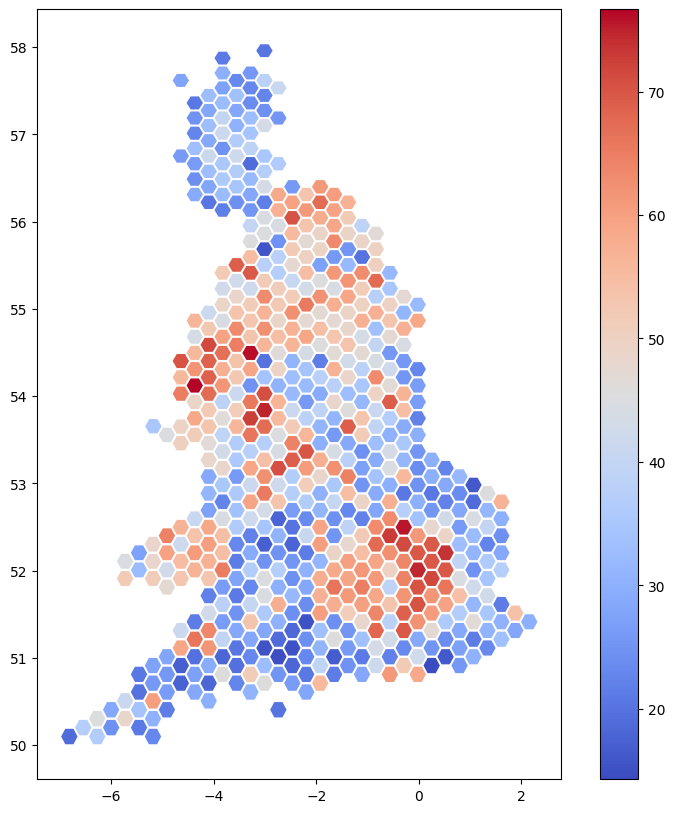

In [233]:
# plot the map

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

uk.plot(column = 'lab_predictions', ax=ax, legend=True, colormap='coolwarm')

plt.show()


In [228]:
uk

,objct_d,cnsttn_,dscrptn,ONSCnID,regn_nm,shp_lng,shape_r,prty_cl,wnnr_19,geometry
0,1,North Thanet,Westminster Constituency,E14000852,South East Euro Region,106798.877597,8.231572e+08,#0087DC,Conservative,"POLYGON ((1.99382 51.41503, 2.07377 51.50131, ..."
1,2,Canterbury,Westminster Constituency,E14000619,South East Euro Region,106798.887591,8.231573e+08,#DC241F,Labour,"POLYGON ((1.72200 51.51465, 1.80194 51.60074, ..."
2,3,South Thanet,Westminster Constituency,E14000948,South East Euro Region,106798.924488,8.231579e+08,#0087DC,Conservative,"POLYGON ((1.72200 51.31520, 1.80194 51.40167, ..."
3,4,Norwich South,Westminster Constituency,E14000864,Eastern Euro Region,106799.371719,8.231648e+08,#DC241F,Labour,"POLYGON ((1.45017 52.78994, 1.53012 52.87360, ..."
4,5,Great Yarmouth,Westminster Constituency,E14000717,Eastern Euro Region,106799.363204,8.231647e+08,#0087DC,Conservative,"POLYGON ((1.45017 52.59612, 1.53012 52.68015, ..."
...,...,...,...,...,...,...,...,...,...,...
627,628,South East Cornwall,Westminster Constituency,E14000938,South West Euro Region,106799.297297,8.231636e+08,#0087DC,Conservative,"POLYGON ((-6.16101 50.20262, -6.08106 50.29118..."
628,629,St. Austell and Newquay,Westminster Constituency,E14000961,South West Euro Region,106799.347186,8.231644e+08,#0087DC,Conservative,"POLYGON ((-6.43284 50.30486, -6.35289 50.39322..."
629,630,Truro and Falmouth,Westminster Constituency,E14001003,South West Euro Region,106799.105935,8.231607e+08,#0087DC,Conservative,"POLYGON ((-6.43284 50.10017, -6.35289 50.18891..."
630,631,Camborne and Redruth,Westminster Constituency,E14000616,South West Euro Region,106799.292381,8.231636e+08,#0087DC,Conservative,"POLYGON ((-6.70467 50.20262, -6.62472 50.29118..."


In [235]:
for i,j in zip(uk.ONSCnID, uk.lab_predictions):
    print(i,j)

E14000852 29.957508087158203
E14000619 53.96996307373047
E14000948 28.185375213623047
E14000864 56.77711486816406
E14000717 29.952388763427734
E14000806 24.500282287597656
E14000957 28.42675018310547
E14000899 37.385902404785156
E14000536 21.339933395385742
E14000927 30.196624755859375
E14000670 33.319461822509766
E14000863 45.1362190246582
E14000941 31.417972564697266
E14001022 40.042198181152344
E14000888 22.359119415283203
E14000622 36.09724044799805
E14000933 34.56784439086914
E14000898 42.732330322265625
E14000711 34.8350830078125
E14000700 30.78476905822754
E14000704 23.473133087158203
E14000848 16.008970260620117
E14000981 18.872177124023438
E14000761 44.394161224365234
E14000642 32.36750411987305
E14000594 30.938140869140625
E14000544 24.770830154418945
E14000995 42.462432861328125
E14000715 31.418825149536133
E14000626 46.460575103759766
E14000804 21.204811096191406
E14000735 30.371583938598633
E14000603 31.83278465270996
E14000624 23.602279663085938
E14000946 28.478515625
E14